# Predicting Financial Distress Notebook
- Dataset can be found at: https://www.kaggle.com/c/GiveMeSomeCredit
    - Contains historical data on 150,000 borrowers
        - Labels are binary: defaulted or didn't default (SeriousDlqin2yrs)
    - Goal is to predict default risk on holdout set

In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import Counter

import seaborn as sns

In [46]:
# Read CSV
#df = pd.read_csv('../data/cs-test.csv')
df = pd.read_csv('../data/cs-training.csv')
df = df.drop('Unnamed: 0', axis=1)

In [47]:
# Clean column names
cleanCol = []
for i in range(len(df.columns)):
    cleanCol.append(df.columns[i].replace('-', 'to'))
    
df.columns = cleanCol

In [48]:
# Calculate std dev values
def findStd(series,num):
    mean = series.mean()
    stdDev = series.std()
    std_pos = mean + num*stdDev
    std_neg = mean - num*stdDev
    
    stdValues = {
        'std+': std_pos,
        'std-': std_neg
    }
    
    return stdValues

In [49]:
def standardizeValues(dfColumn,stdRet,columnName,classifier='mean',compareColumn='N/A',lookupTable='N/A'):
    if classifier == 'lookup':
        df.loc[dfColumn.isnull(),columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn>stdRet['std+'],columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn<stdRet['std-'],columnName] = compareColumn.map(lookupTable)
    elif classifier == 'median':
        df.loc[dfColumn.isnull(),columnName] = dfColumn.median()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.median()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.median()
    else:
        df.loc[dfColumn.isnull(),columnName] = dfColumn.mean()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.mean()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.mean()

In [50]:
def standardizePlaceholders(dfColumn,columnName,classifier='mean'):
    if classifier == 'median':
        df.loc[dfColumn==98,columnName] = dfColumn.median()
        df.loc[dfColumn==96,columnName] = dfColumn.median()
        
    else:
        df.loc[dfColumn==98,columnName] = dfColumn.mean()
        df.loc[dfColumn==98,columnName] = dfColumn.mean()

In [51]:
# Get std deviation and replace outliers
ageStd = findStd(df.age,3)
standardizeValues(df.age,ageStd,'age')
df.age = df.age.astype(int)

In [52]:
# Drop NAN from OG DF
df_MI = df[['age','MonthlyIncome']]

In [53]:
df_MIsansNAN = df_MI.dropna(axis=0, how='any')

# Remove Income Outliers outside of 3 STD
df_MIsansNAN_std = df_MIsansNAN[np.abs(df_MIsansNAN.MonthlyIncome-df_MIsansNAN.MonthlyIncome.mean())<=(3*df_MIsansNAN.MonthlyIncome.std())]

In [54]:
# Create lookup table for mean per age
ageSalaryLookup = pd.DataFrame(df_MIsansNAN_std.groupby(['age']).MonthlyIncome.mean())

In [55]:
# Find all values 3x std
incomeStd = findStd(df_MIsansNAN_std.MonthlyIncome,3)
standardizeValues(df.MonthlyIncome,incomeStd,'MonthlyIncome','lookup',df.age,ageSalaryLookup.MonthlyIncome)

In [56]:
# Define deviation and replace outliers
revLnStd = {'std+': 2, 'std-': 0}
standardizeValues(df.RevolvingUtilizationOfUnsecuredLines,revLnStd,'RevolvingUtilizationOfUnsecuredLines','median')

In [57]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime30to59DaysPastDueNotWorse,'NumberOfTime30to59DaysPastDueNotWorse','median')

In [58]:
debtRatioStd = {'std+': 2, 'std-': 0}
standardizeValues(df.DebtRatio,debtRatioStd,'DebtRatio','median')

In [59]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTimes90DaysLate,'NumberOfTimes90DaysLate','median')
df.NumberOfTimes90DaysLate = df.NumberOfTimes90DaysLate.astype(int)

In [60]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime60to89DaysPastDueNotWorse,'NumberOfTime60to89DaysPastDueNotWorse','median')
df.NumberOfTime60to89DaysPastDueNotWorse = df.NumberOfTime60to89DaysPastDueNotWorse.astype(int)

In [61]:
# Drop NAN from OG DF
df_D = df[['NumberOfDependents']]
df_DsansNAN = df_D.dropna(axis=0, how='any')

In [62]:
# Define deviation and replace outliers
depStd = {'std+': df.NumberOfDependents.max(), 'std-': df.NumberOfDependents.min()}
standardizeValues(df.NumberOfDependents,depStd,'NumberOfDependents','median')

In [63]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,0.0,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.000000,101503.00000
mean,NaN,0.320824,52.395841,0.247175,0.342855,6202.676927,8.453514,0.090096,1.013074,0.063722,0.74915
std,NaN,0.356194,14.764929,0.705744,0.263033,3463.928984,5.144100,0.477789,1.110253,0.326523,1.12860
min,NaN,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,NaN,0.030131,41.000000,0.000000,0.173423,3800.000000,5.000000,0.000000,0.000000,0.000000,0.00000
50%,NaN,0.152586,52.000000,0.000000,0.364260,5943.275392,8.000000,0.000000,1.000000,0.000000,0.00000
75%,NaN,0.558135,63.000000,0.000000,0.405120,7503.129305,11.000000,0.000000,2.000000,0.000000,1.00000
max,NaN,2.000000,96.000000,19.000000,2.000000,23620.000000,85.000000,18.000000,37.000000,9.000000,43.00000


### Add MonthlyCosts column

In [64]:
# write function to multiply DebtRatio by MonthlyIncome and put the result in a new column
def add_monthlycosts_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['MonthlyCosts'] = dataframe_copy['DebtRatio'] * dataframe_copy['MonthlyIncome']
    
    return dataframe_copy

### Add IncomePerDependent column

In [65]:
# write function to divide MonthlyIncome by (NumberOfDependents + 1) and put the result in a new column
def add_incomeperdependent_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['IncomePerDependent'] = dataframe_copy['MonthlyIncome'] / (dataframe_copy['NumberOfDependents'] + 1)
    
    return dataframe_copy

### Add NumTimesPastDue column

In [66]:
# write function to divide MonthlyIncome by (NumberOfDependents + 1) and put the result in a new column
# the function also drops the original columns
def add_numtimespastdue_column(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy['NumTimesPastDue'] = (dataframe_copy['NumberOfTime30to59DaysPastDueNotWorse'] +
                                         dataframe_copy['NumberOfTime60to89DaysPastDueNotWorse'] +
                                         dataframe_copy['NumberOfTimes90DaysLate'])
    
    dataframe_copy = dataframe_copy.drop('NumberOfTime30to59DaysPastDueNotWorse', axis=1)
    dataframe_copy = dataframe_copy.drop('NumberOfTime60to89DaysPastDueNotWorse', axis=1)
    dataframe_copy = dataframe_copy.drop('NumberOfTimes90DaysLate', axis=1)
    
    return dataframe_copy

### Function to write indicator variable columns:

In [67]:
# define function to label rows with high monthly income with a 1 (in a new column)
def add_indicator_column(dataframe, threshold, column_name, direction='above'):
    dataframe_copy = dataframe.copy()
    labels = []
    if direction == 'above':
        for index, row in dataframe_copy.iterrows():
            value = row[column_name]
            if value >= threshold:
                labels.append(float(1))
            elif value < threshold:
                labels.append(float(0))
            else:
                print('Error in add_indicator_column(): Base case reached')
    elif direction == 'below':
        for index, row in dataframe_copy.iterrows():
            value = row[column_name]
            if value <= threshold:
                labels.append(float(1))
            elif value > threshold:
                labels.append(float(0))
            else:
                print('Error in add_indicator_column(): Base case reached')
    if len(dataframe_copy) == len(labels):
        dataframe_copy[(str(column_name) + '_' + str(direction) + str(threshold))] = pd.Series(labels)
    else:
        print('Error in add_indicator_column(): Missing labels')
    return dataframe_copy

In [68]:
# outside of function

# feature engineering steps
# dataframe_copy = add_incomeoverrevolving_column(dataframe_copy)


df = add_monthlycosts_column(df)

df = add_incomeperdependent_column(df)
df = add_numtimespastdue_column(df)
df = add_indicator_column(df, 10000, 'MonthlyIncome', direction='above')
df = add_indicator_column(df, 5, 'NumTimesPastDue', direction='below')
df = add_indicator_column(df, 21, 'age', direction='below')
df = add_indicator_column(df, 65, 'age', direction='above')
    
# dropping multicollinear features
df = df.drop('DebtRatio', axis=1)

### Check for multicollinearity
- new features, new possible multicollinearities

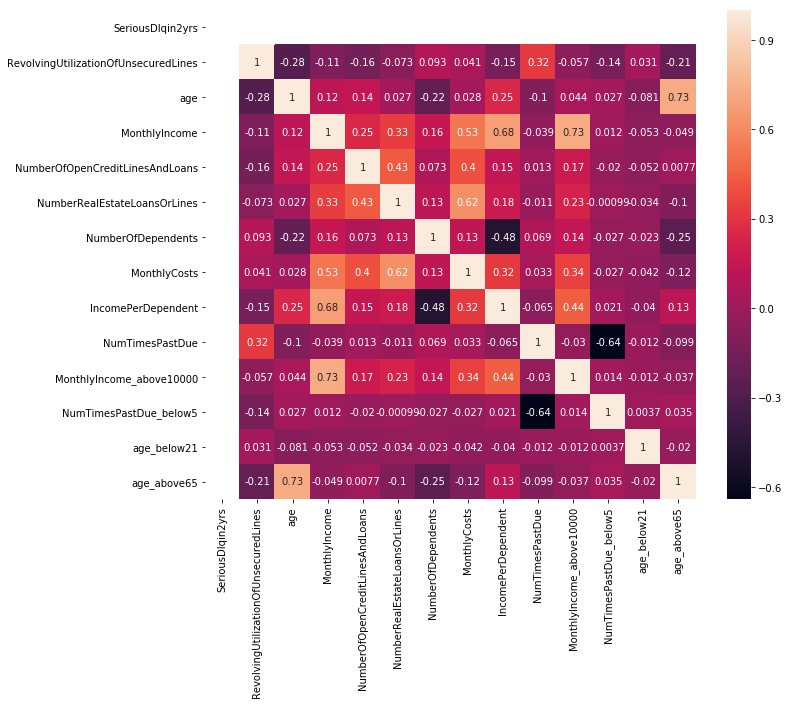

In [69]:
plt.figure(figsize=(11,9))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

In [73]:
# for kaggle
# X_test_kaggle = df.drop('SeriousDlqin2yrs', axis=1)
# X_test_scaled_kaggle = X_scaler.transform(X_test_kaggle)

## Fit Scaler and Transform Data


In [26]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df.SeriousDlqin2yrs

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# fit StandardScaler and use it to transform both training and testing data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fit Model and Make Predictions
- will try:
    - Logistic Regression
    - Random Forest
    - Gradient Boosted Classifier
    
#### Note: What is returned from ```model.predict_proba()``` is an array with the probability of each class for a given row
- negative class (no default in our case) is in the first column of the array, positive in the second
- ```roc_curve()``` function takes at least two arguments:
    - first, the true labels
    - second, the probability of the positive class (defaulted, in our case)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score

### Logistic Regression

LR AUC Training: 0.854405858638
LR AUC Testing: 0.854979880172


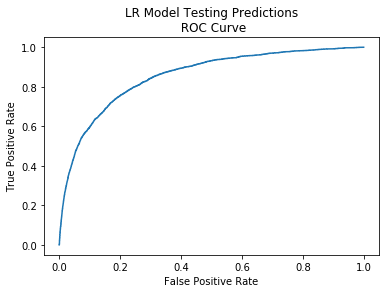

In [30]:
# instantiate logistic regression model
lr_model = LogisticRegression(penalty='l2',
                           dual=False,
                           tol=0.0001,
                           C=1.0,
                           fit_intercept=True,
                           intercept_scaling=1,
                           class_weight='balanced',
                           random_state=None,
                           solver='liblinear',
                           max_iter=100,
                           multi_class='ovr',
                           verbose=0,
                           warm_start=False,
                           n_jobs=1)

lr_model.fit(X_train_scaled, y_train)
lr_probability_predictions_training = lr_model.predict_proba(X_train_scaled)[:,1]
lr_probability_predictions_testing = lr_model.predict_proba(X_test_scaled)[:,1]

lr_fpr_testing, lr_tpr_testing, lr_thresholds_testing = roc_curve(y_test, lr_probability_predictions_testing)

print('LR AUC Training:', roc_auc_score(y_train, lr_probability_predictions_training))
print('LR AUC Testing:', roc_auc_score(y_test, lr_probability_predictions_testing))
plt.title('LR Model Testing Predictions\n ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(lr_fpr_testing, lr_tpr_testing)

#### Check model coefficients to gauge feature importance (LogReg only)

In [31]:
coefficients = list(lr_model.coef_)
X_cols = list(X_train.columns)

for i in range(0, len(coefficients[0])):
    print(X_cols[i], 'feature strength: ', coefficients[0][i])
    print('---------')

RevolvingUtilizationOfUnsecuredLines feature strength:  0.722076294204
---------
age feature strength:  -0.277439090516
---------
MonthlyIncome feature strength:  -0.302852163067
---------
NumberOfOpenCreditLinesAndLoans feature strength:  0.137420701945
---------
NumberRealEstateLoansOrLines feature strength:  0.0613520789476
---------
NumberOfDependents feature strength:  0.0705370142621
---------
MonthlyCosts feature strength:  0.164676376932
---------
IncomePerDependent feature strength:  0.0763477487758
---------
NumTimesPastDue feature strength:  0.908126403589
---------
MonthlyIncome_above10000 feature strength:  0.0252494201048
---------
NumTimesPastDue_below5 feature strength:  0.248274399008
---------
age_below21 feature strength:  -0.0181550160799
---------
age_above65 feature strength:  -0.0138824969109
---------


In [32]:
lr_model.coef_

array([[ 0.72207629, -0.27743909, -0.30285216,  0.1374207 ,  0.06135208,
         0.07053701,  0.16467638,  0.07634775,  0.9081264 ,  0.02524942,
         0.2482744 , -0.01815502, -0.0138825 ]])

### Random Forest

RF AUC Training: 0.893190139327
RF AUC Testing: 0.863614024614


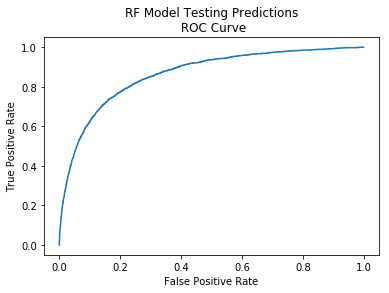

In [33]:
# instantiate random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000,
                               criterion='gini',
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=80,
                               min_weight_fraction_leaf=0.0,
                               max_features='auto',
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.0,
                               min_impurity_split=None,
                               bootstrap=True,
                               oob_score=False,
                               n_jobs=-1,
                               random_state=None,
                               verbose=0,
                               warm_start=False,
                               class_weight=None)

rf_model.fit(X_train_scaled, y_train)
rf_probability_predictions_training = rf_model.predict_proba(X_train_scaled)[:,1]
rf_probability_predictions_testing = rf_model.predict_proba(X_test_scaled)[:,1]

rf_fpr_testing, rf_tpr_testing, rf_thresholds_testing = roc_curve(y_test, rf_probability_predictions_testing)

print('RF AUC Training:', roc_auc_score(y_train, rf_probability_predictions_training))
print('RF AUC Testing:', roc_auc_score(y_test, rf_probability_predictions_testing))
plt.title('RF Model Testing Predictions\n ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(rf_fpr_testing, rf_tpr_testing)

### Gradient Boosted Model

GBM AUC Training: 0.874877298021
GBM AUC Testing: 0.863815519939


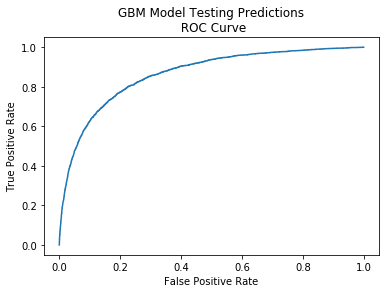

In [34]:
# instantiate gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(loss='exponential',
                           learning_rate=0.11,
                           n_estimators=253,
                           subsample=1.0,
                           criterion='friedman_mse',
                           min_samples_split=14,
                           min_samples_leaf=2,
                           min_weight_fraction_leaf=0.0,
                           max_depth=3,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           init=None,
                           random_state=None,
                           max_features=None,
                           verbose=0,
                           max_leaf_nodes=None,
                           warm_start=False,
                           presort='auto')

gbm_model.fit(X_train_scaled, y_train)
gbm_probability_predictions_training = gbm_model.predict_proba(X_train_scaled)[:,1]
gbm_probability_predictions_testing = gbm_model.predict_proba(X_test_scaled)[:,1]

gbm_fpr_testing, gbm_tpr_testing, gbm_thresholds_testing = roc_curve(y_test, gbm_probability_predictions_testing)

print('GBM AUC Training:', roc_auc_score(y_train, gbm_probability_predictions_training))
print('GBM AUC Testing:', roc_auc_score(y_test, gbm_probability_predictions_testing))
plt.title('GBM Model Testing Predictions\n ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr_testing, gbm_tpr_testing)

## Hypertune Model Parameters

- raw model AUC:  0.853451874923 (634 on leaderboard)
- w/ class_weight='balanced': 0.854979880172 (616 on leaderboard)
- random forest with min_samples_leaf=100: 0.858824995133 (557 on leaderboard)
- random forest with min_samples_leaf=100 and n_estimators=1000: 0.863349803531 (454 on leaderboard)
- random forest with min_samples_leaf=100 and n_estimators=1000 and class_weight='balanced': lower than above
- random forest with min_samples_leaf=80 and n_estimators=1000: 0.863535535224 (448 on leaderboard)
- random forest with min_samples_leaf=80 and n_estimators=10000: 0.863556241934 (445 on leaderboard)
- random forest with min_samples_leaf=80, n_estimators=1000, max_depth=5: 0.863556241934 (445 on leaderboard)
- ensemble of:
    - random forest with min_samples_leaf=80, n_estimators=1000, max_depth=5
    - gradient boosted classifier with loss='exponential', n_estimators=200, min_samples_leaf=14
        - AUC: 0.86471986676183676 (287 on leaderboard)


### Logistic Regression

In [35]:
# # logistic regression parameter tuning loop

# #parameter_options = np.arange(10,50,5) 2, 80
# parameter_options = [1000, 2000]

# for parameter in parameter_options:

#     lr_model = LogisticRegression(penalty='l2',
#                            dual=False,
#                            tol=0.0001,
#                            C=1.0,
#                            fit_intercept=True,
#                            intercept_scaling=1,
#                            class_weight='balanced',
#                            random_state=None,
#                            solver='liblinear',
#                            max_iter=100,
#                            multi_class='ovr',
#                            verbose=0,
#                            warm_start=False,
#                            n_jobs=1)

#     lr_model.fit(X_train_scaled, y_train)
        
#     lr_model_class_probability_predictions = lr_model.predict_proba(X_test_scaled)
#     lr_model_default_predictions = lr_model_class_probability_predictions[:,1]
        
#     print("Parameter", parameter,"AUC - ROC : ", roc_auc_score(y_test, lr_model_default_predictions))
#     plt.ylim(0.85, 0.87)
#     plt.bar(parameter, roc_auc_score(y_test, lr_model_default_predictions))

### Random Forest

In [36]:
# # random forest parameter tuning loop

# #parameter_options = np.arange(10,50,5) 2, 80
# parameter_options = [1000, 2000]

# for parameter in parameter_options:

#     rf_model = RandomForestClassifier(n_estimators=1000, 
#                                    criterion='gini',
#                                    max_depth=None,
#                                    min_samples_split=2,
#                                    min_samples_leaf=80,
#                                    min_weight_fraction_leaf=0.0,
#                                    max_features='auto',
#                                    max_leaf_nodes=None,
#                                    min_impurity_decrease=0.0,
#                                    min_impurity_split=None,
#                                    bootstrap=True,
#                                    oob_score=False,
#                                    n_jobs=-1,
#                                    random_state=None,
#                                    verbose=0,
#                                    warm_start=False,
#                                    class_weight=None)

#     rf_model.fit(X_train_scaled, y_train)
        
#     rf_model_class_probability_predictions = rf_model.predict_proba(X_test_scaled)
#     rf_model_default_predictions = rf_model_class_probability_predictions[:,1]
        
#     print("Parameter", parameter,"AUC - ROC : ", roc_auc_score(y_test, rf_model_default_predictions))
#     plt.ylim(0.85, 0.87)
#     plt.bar(parameter, roc_auc_score(y_test, rf_model_default_predictions))

### Gradient Boosted Classifier

In [37]:
# # gradient boosted classifier parameter tuning loop

# #parameter_options = np.arange(10,50,5) 2, 80
# parameter_options = [1000, 2000]

# for parameter in parameter_options:

#     gbm_model = GradientBoostingClassifier(loss='exponential',
#                            learning_rate=0.11,
#                            n_estimators=253,
#                            subsample=1.0,
#                            criterion='friedman_mse',
#                            min_samples_split=14,
#                            min_samples_leaf=2,
#                            min_weight_fraction_leaf=0.0,
#                            max_depth=3,
#                            min_impurity_decrease=0.0,
#                            min_impurity_split=None,
#                            init=None,
#                            random_state=None,
#                            max_features=None,
#                            verbose=0,
#                            max_leaf_nodes=None,
#                            warm_start=False,
#                            presort='auto')

#     gbm_model.fit(X_train_scaled, y_train)
        
#     gbm_model_class_probability_predictions = gbm_model.predict_proba(X_test_scaled)
#     gbm_model_default_predictions = gbm_model_class_probability_predictions[:,1]
        
#     print("Parameter", parameter,"AUC - ROC : ", roc_auc_score(y_test, gbm_model_default_predictions))
#     plt.ylim(0.85, 0.87)
#     plt.bar(parameter, roc_auc_score(y_test, gbm_model_default_predictions))

## Test Ensemble of Best Models
- Will test ensemble of two best models, rf and gbm

In [38]:
# average of two arrays
ensemble_predictions = (rf_probability_predictions_testing + gbm_probability_predictions_testing) / 2
ensemble_predictions                   

array([ 0.0043324 ,  0.00886722,  0.01175764, ...,  0.18741607,
        0.03796769,  0.01243833])

In [39]:
roc_auc_score(y_test, ensemble_predictions)

0.86475870770517449

In [40]:
#0.86472002826264049 (0.0)

## Export Best Model(s)
- for application, each model will be run, two outputs will be averaged.
    - above 0.5 is 'will default'
    - below 0.5 is 'won't default'

In [41]:
from sklearn.externals import joblib

joblib.dump(rf_model, '../model/rf_model_v1.pkl')
joblib.dump(gbm_model, '../model/gbm_model_v1.pkl')

['../model/gbm_model_v1.pkl']

#### Remember feature order for model.predict():


In [43]:
print('Argument # :  Feature')
print('-----------------------')
for i in range(0, len(X.columns)):
    print(i, ': ', X.columns[i])

Argument # :  Feature
-----------------------
0 :  RevolvingUtilizationOfUnsecuredLines
1 :  age
2 :  MonthlyIncome
3 :  NumberOfOpenCreditLinesAndLoans
4 :  NumberRealEstateLoansOrLines
5 :  NumberOfDependents
6 :  MonthlyCosts
7 :  IncomePerDependent
8 :  NumTimesPastDue
9 :  MonthlyIncome_above10000
10 :  NumTimesPastDue_below5
11 :  age_below21
12 :  age_above65


## Kaggle Submission (for fun)

In [74]:
# rf_predictions = rf_model.predict_proba(X_test_scaled_kaggle)[:,1]
# gbm_predictions = gbm_model.predict_proba(X_test_scaled_kaggle)[:,1]
# ensemble_predictions = (rf_predictions + gbm_predictions) / 2
# ids = np.arange(1,101504)
# submission = pd.DataFrame( {'Id': ids, 'Probability': ensemble_predictions})
# submission.to_csv('kaggle_submission.csv', index=False)